In [1]:
import glob, sys, re
import numpy as np
from collections import defaultdict, OrderedDict
from lasagne_utils import load_log
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
font = {'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import theano.tensor as T
import lasagne, theano

def get_rainbow_colors(log_list, kind='gist_rainbow'):
    num_keys = len(log_list)
    cm = plt.get_cmap(kind)
    color_dict = {grp_key: cm(1.*i/(num_keys)) for i, grp_key in enumerate(log_list)}
    return color_dict

dataset = '/home/dneil/datasets/driving/rec1487864316_bin5k.hdf5'

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5004)


driving_cnn_19.4_aps_multi_final, last : Train: 180.726285, Test: 1513.067190


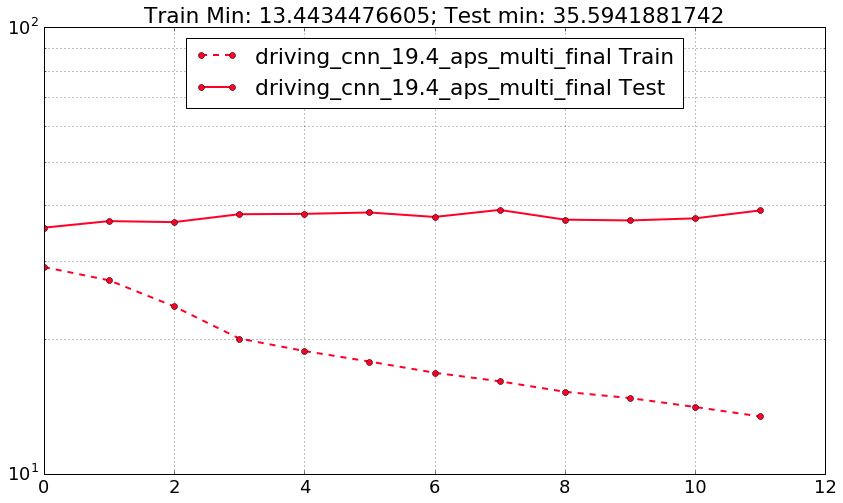

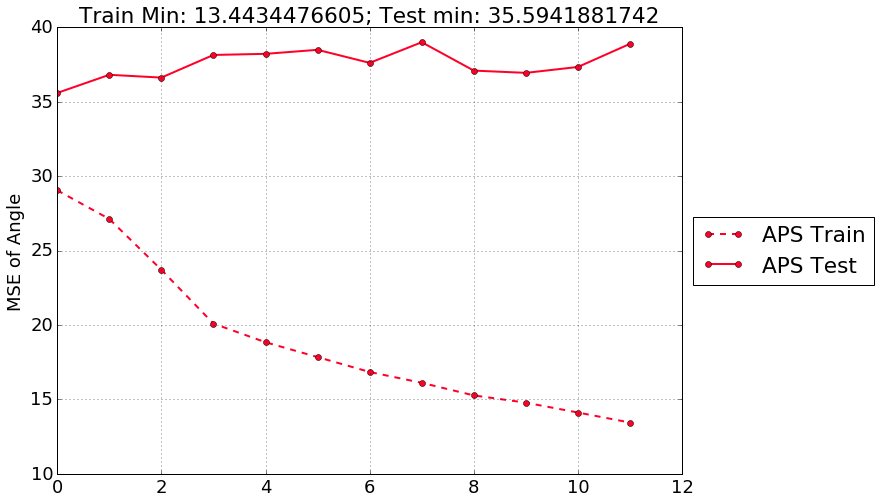

In [10]:
filenames = ['driving_cnn_19.4_aps_multi_final']

colors = get_rainbow_colors(filenames)

# Load history from file
plt.figure(figsize=(14,8))
minval = 1e8
mintrain = 1e8
for filename in filenames:
    history = load_log(filename)
    plt.semilogy(map(np.sqrt, history['train_err']), 'o--', label=filename+' Train', color=colors[filename], lw=2)
    plt.semilogy(map(np.sqrt, history['test_err']), 'o-', label=filename+' Test', color=colors[filename], lw=2)
    minval = np.min([minval] + list(map(np.sqrt, history['test_err'])))
    mintrain = np.min([mintrain] + list(map(np.sqrt, history['train_err'])))
plt.legend(loc='upper center')
plt.grid(which='both')
plt.title('Train Min: {}; Test min: {}'.format(mintrain, minval))

plt.figure(figsize=(14,8))
for filename in filenames:
    if '_aps_' in filename:
        label = 'APS'
    if '_dvs5k_' in filename:
        label = 'DVS 5k'        
    if '_dvs10ms_' in filename:
        label = 'DVS 10ms'                
    history = load_log(filename)
    plt.plot(map(np.sqrt, history['train_err']), 'o--', label=label+' Train', color=colors[filename], lw=2)
    plt.plot(map(np.sqrt, history['test_err']), 'o-', label=label+' Test', color=colors[filename], lw=2)
    print('{}, last : Train: {:.6f}, Test: {:.6f}'.format(filename, 
        history['train_err'][-1], history['test_err'][-1]))
plt.grid(which='both')
plt.title('Train Min: {}; Test min: {}'.format(mintrain, minval))
plt.ylabel('MSE of Angle')


# Shrink current axis by 20%
ax = plt.gca()
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('results_acc.png')

In [3]:
from hdf5_deeplearn_utils import HDF5VisualIterator
from train_test_cnn import get_simple_driving_cnn
from lasagne_utils import get_output_fn, load_model
import time, h5py

h5_filenames = ['/home/dneil/datasets/driving/rec1487858093_frames.hdf5', 
#     '/home/dneil/datasets/driving/rec1487858093_bin5k.hdf5',                 
    '/home/dneil/datasets/driving/rec1487858093_bin10ms.hdf5']
net_filenames = ['driving_cnn_19.4_aps_rec1487858093_final', 
#                  'driving_cnn_19.4_dvs5k_rec1487858093_final', 
                 'driving_cnn_19.4_dvs10ms_rec1487858093_final']

dataset_keys = ['aps_frame_60x80', 'dvs_frame_60x80', 'dvs_frame_60x80']

d = HDF5VisualIterator()

# Create symbolic vars
vid_in = T.ftensor4('vid_in')

# Build model
print("Building network ...")
network = get_simple_driving_cnn(vid_in)
print("Compiling network ...")
out_fn = get_output_fn([vid_in], network)

out_angles = defaultdict(list)
out_times = defaultdict(list)
for h5f_name, net_filename, dataset_key in zip(h5_filenames, net_filenames, dataset_keys):
    start_time = time.time()
    # Load parameters
    load_model(net_filename, network)
    h5f = h5py.File(h5f_name, 'r')

    # Get all angles
    for data in d.flow(h5f, dataset_key, 'test_idxs', batch_size=128, shuffle=False):
        vid_in, bY = data
        out_angles[net_filename].extend(out_fn(vid_in))
        out_angles[net_filename+'_true'].extend(bY)
    
    # Get timestamps
    print(h5f['timestamp'][0])
    test_idxs = list(h5f['test_idxs'])
    out_times[net_filename] = h5f['timestamp'][test_idxs]
    h5f.close()
    print('{} completed in {:.2f}s.'.format(net_filename, time.time()-start_time))

Building network ...
Compiling network ...
1830.335798
driving_cnn_19.4_aps_rec1487858093_final completed in 1.49s.
1830.333772
driving_cnn_19.4_dvs10ms_rec1487858093_final completed in 9.96s.


(-360, 360)

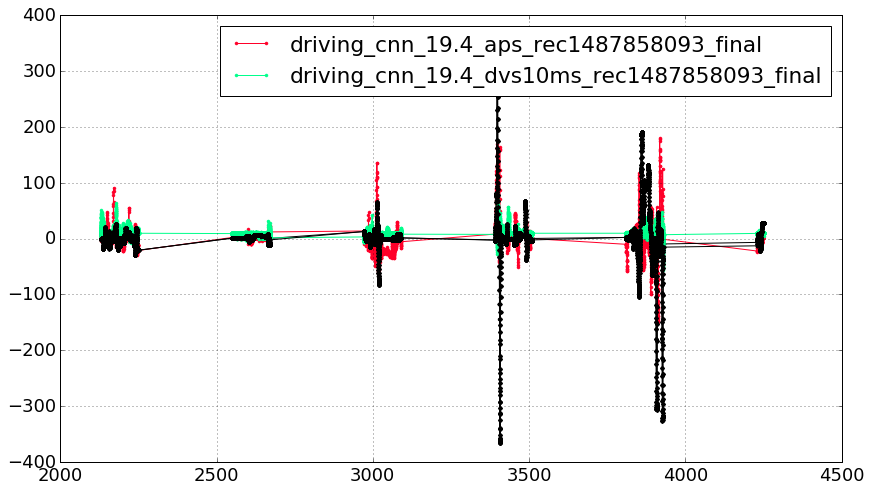

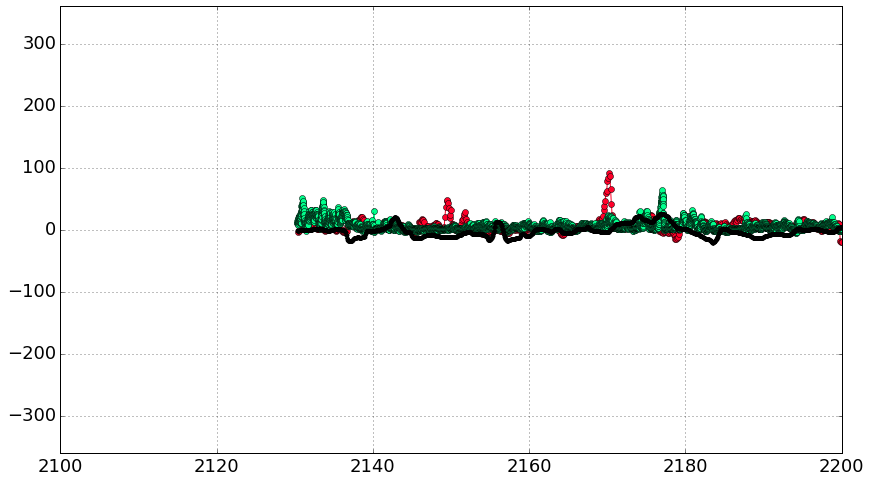

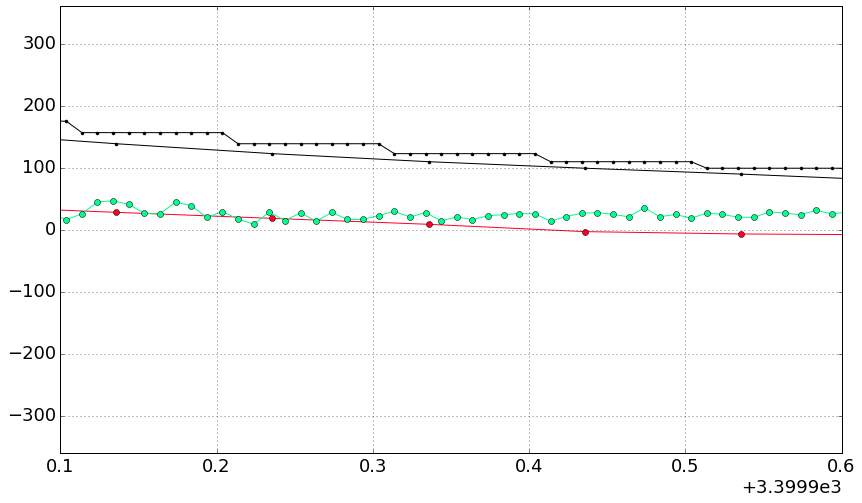

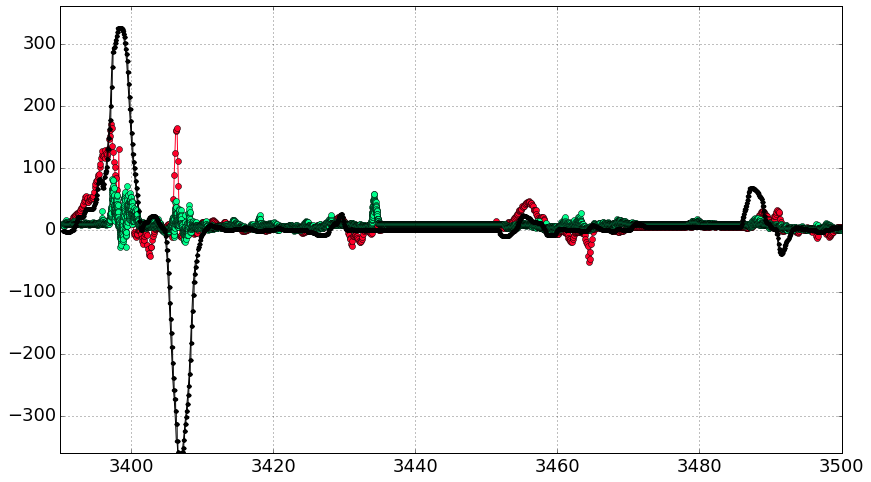

In [4]:
# zoom_region = [3851, 3853]
zoom_region = [3400, 3400.5]

plt.figure(figsize=(14,8))
colors = get_rainbow_colors(net_filenames)
for key in net_filenames:
    plt.plot(out_times[key], out_angles[key], '.-', color=colors[key], label=key)
    plt.plot(out_times[key], out_angles[key+'_true'], '.-', color='k')    
plt.grid(which='both')
plt.legend()

plt.figure(figsize=(14,8))
colors = get_rainbow_colors(net_filenames)
for key in net_filenames:
    plt.plot(out_times[key], out_angles[key], 'o-', color=colors[key])
    plt.plot(out_times[key], out_angles[key+'_true'], '.-', color='k')    
plt.grid(which='both')
plt.xlim([2100, 2200])
plt.ylim([-360, 360])

plt.figure(figsize=(14,8))
colors = get_rainbow_colors(net_filenames)
for key in net_filenames:
    plt.plot(out_times[key], out_angles[key], 'o-', color=colors[key])
    plt.plot(out_times[key], out_angles[key+'_true'], '.-', color='k')    
plt.grid(which='both')
plt.xlim(zoom_region)
plt.ylim([-360, 360])

plt.figure(figsize=(14,8))
colors = get_rainbow_colors(net_filenames)
for key in net_filenames:
    plt.plot(out_times[key], out_angles[key], 'o-', color=colors[key])
    plt.plot(out_times[key], out_angles[key+'_true'], '.-', color='k')    
plt.grid(which='both')
plt.xlim([3390, 3500])
plt.ylim([-360, 360])

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import matplotlib.patches as mpatches

# plt.rcParams['savefig.bbox'] = 'tight'     # tight garbles the video!!!

aps_key = 'driving_cnn_19.4_aps_rec1487858093_final'
dvs_key = 'driving_cnn_19.4_dvs10ms_rec1487858093_final'

net_filename_aps = 'driving_cnn_19.4_aps_rec1487858093_final'
net_filename_dvs = 'driving_cnn_19.4_dvs10ms_rec1487858093_final'
h5_filename_aps = '/home/dneil/datasets/driving/rec1487858093_frames.hdf5'
h5_filename_dvs = '/home/dneil/datasets/driving/rec1487858093_bin10ms.hdf5'
h5faps = h5py.File(h5_filename_aps, 'r')
h5fdvs = h5py.File(h5_filename_dvs, 'r')

def get_closest_idx(times, targ_time):
    first_bigger = np.argwhere(np.array(times)>=targ_time).flatten()[0]
    last_smaller = first_bigger - 1 if first_bigger > 0 else 0
    if abs(times[last_smaller]-targ_time) < abs(times[first_bigger]-targ_time):
        return last_smaller
    else:
        return first_bigger

def get_center_radius(kind):
    if kind=='aps':
        c, r = (173., 130.), 65. #center, radius
    if kind=='dvs':
        c, r = (40., 30.), 15. #center, radius
    return c, r

def plot_steering_angle(ax, angle, angle_guess, kind='aps', other_color='b'):
    c,r = get_center_radius(kind)
    a_rad = float(angle) / 180. * np.pi + np.pi / 2
    t = (c[0] + np.cos(a_rad) * r, c[1] - np.sin(a_rad) * r)
    ax.add_artist(mpatches.Circle(c, r, edgecolor='r', facecolor='none'))
    angle_line, = ax.plot((c[0], t[0]), (c[1], t[1]), 'r', lw=2, zorder='2')    
    angle_line_guess, = ax.plot((c[0], t[0]), (c[1], t[1]), other_color, lw=2, zorder='2')    
    # text = plt.text(c[0], c[1]+30, '{:0.1f} deg'.format(angle), color='r')
    text = None
    return angle_line, angle_line_guess, text

def plot_angle_on_top(angle, h_l, kind):
    c,r = get_center_radius(kind)
    a_rad = angle / 180. * np.pi + np.pi / 2    
    t = (c[0] + int(np.cos(a_rad) * r), c[1] - int(np.sin(a_rad) * r))    
    h_l.set_data((c[0], t[0]), (c[1], t[1]))
    # h_t.set_text(angle)
print('Functions defined.')

Functions defined.


In [ ]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='DVS 10ms Slice Driving Data')
writer = FFMpegWriter(fps=60, metadata=metadata, bitrate=-1, codec="libx264")

fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 2), (0, 1), rowspan=2)
ax3 = plt.subplot2grid((3, 2), (2, 0), colspan=3)
plt.subplots_adjust(hspace=0.05, wspace=0.05)

dvs_im = ax1.imshow(np.zeros((60, 80)), interpolation='nearest', cmap='gray')
ax1.set_title('DVS 10ms Time Slices')
ax1.set_ylim([0, 59])
ax1.set_xlim([79, 0])
dvs_im.set_clim([0.45, 0.55])
ax1.axis('off')
ax1.invert_yaxis()
# ax1.tight_layout()
dvs_angle_line, dvs_angle_guess, text = plot_steering_angle(ax1, 0, 0, 'dvs')

aps_im = ax2.imshow(np.zeros((60, 80)), interpolation='nearest', cmap='gray')
ax2.set_title('APS Frames')
ax2.set_ylim([0, 59])
ax2.set_xlim([79, 0])
aps_im.set_clim([0, 1.])
ax2.axis('off')
ax2.invert_yaxis()
# Get handles for the angles
aps_angle_line, aps_angle_guess, text = plot_steering_angle(ax2, 0, 0, 'aps', other_color='c')

# Plot the angles
h_a, = ax3.plot([0, 0], [1, 1], '.-', color='cyan', label='APS')    
h_t, = ax3.plot([0, 0], [1, 1], '.-', color='red', label='Truth')
h_d, = ax3.plot([0, 0], [1, 1], '.-', color='blue', label='DVS')
ax3.grid(which='both')
ax3.set_ylim([-180, 180])
ax3.get_xaxis().get_major_formatter().set_useOffset(False)
ax3.legend(loc='center right')

START_TIME = 0
DURATION = 150
curr_frame = 0
FPS = 60
means = []
time_window = 2
lookahead = 0.5

print('Beginning write...')
if START_TIME < out_times[dvs_key][0]:
    curr_time = out_times[dvs_key][0]
else:
    curr_time = START_TIME
final_time = curr_time + DURATION

aps_test_idxs = list(h5faps['test_idxs'])
dvs_test_idxs = list(h5fdvs['test_idxs'])
print('Starting at timestamp {}'.format(curr_time))
with writer.saving(fig, 'dvs_aps_jonathan_cnn.mp4', 100):
    start_time = time.time()
    
    while curr_time < final_time:
        # Get data indexes
        aps_result_idx = get_closest_idx(out_times[aps_key], curr_time)
        aps_full_idx = aps_test_idxs[aps_result_idx]
        dvs_result_idx = get_closest_idx(out_times[dvs_key], curr_time)    
        dvs_full_idx = dvs_test_idxs[dvs_result_idx]
        # Get Data
        aps_data = np.array(h5faps['aps_frame_60x80'][aps_full_idx]).astype('float32')/255.
        dvs_data = np.array(h5fdvs['dvs_frame_60x80'][dvs_full_idx]).astype('float32')/255.
        # Plot Data
        aps_im.set_data(aps_data)
        dvs_im.set_data(dvs_data)
        # Plot Angles
        plot_angle_on_top(out_angles[aps_key+'_true'][aps_result_idx], aps_angle_line, 'aps')
        plot_angle_on_top(out_angles[aps_key][aps_result_idx], aps_angle_guess, 'aps')
        plot_angle_on_top(out_angles[dvs_key+'_true'][dvs_result_idx], dvs_angle_line, 'dvs')
        plot_angle_on_top(out_angles[dvs_key][dvs_result_idx], dvs_angle_guess, 'dvs')
        # Plot history
        aps_start, aps_end = get_closest_idx(out_times[aps_key], curr_time-time_window), aps_result_idx
        dvs_start, dvs_end = get_closest_idx(out_times[dvs_key], curr_time-time_window), dvs_result_idx
        h_a.set_data(out_times[aps_key][aps_start:aps_end], out_angles[aps_key][aps_start:aps_end])        
        h_d.set_data(out_times[dvs_key][dvs_start:dvs_end], out_angles[dvs_key][dvs_start:dvs_end])
        h_t.set_data(out_times[dvs_key][dvs_start:dvs_end], out_angles[dvs_key+'_true'][dvs_start:dvs_end])
        ax3.set_xlim([curr_time-time_window, curr_time+lookahead])        
        # Save frame
        writer.grab_frame()
        # Advance
        curr_time += 1./FPS

print('Done with {}s of data in {}s.'.format(DURATION, time.time()-start_time))

In [7]:
plt.figure(figsize=(15,10))
for row, net_name in enumerate(net_filenames):
    for col, frame in enumerate(frames[net_name]):
        plt.subplot(len(net_filenames), 3, row*3+col+1)
        plt.imshow(frame, cmap='gray')
        plt.axis('off')
        if col == 1:
            plt.title('{} at {:.1f}s, {:.1f}s, and {:.1f}s.'.format(net_name, 
                zoom_region[0], np.mean(zoom_region), zoom_region[1]))

NameError: name 'frames' is not defined